# Biweekly Report 3

# Jake Watts

# Xception Activation Functions

For this report I decided to focus on the xcpetion network which I train and test on Cifar-10 data. The Xception architecture was inspired by Inception V3 and replaces Inception modules with depthwise seperable convolutions.

In the paper on Xception (https://arxiv.org/abs/1610.02357) the authors train and test the Xception model using the ReLu activation functiom the ELU activation and finally no activation function between the
depthwise and pointwise operations. They find that no intermediate activation works the best on imagenet data ELU works the second best.

In this section I perform the same comparison of activation functions on the Cifar-10 data rather than the ImageNet data to see if the choice of the optimal activation function remains the same with different data.

Since I am using the same data as last week I did not include any exploratory data analysis for this report.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Add
from tensorflow.keras.layers import SeparableConv2D, ReLU, ELU
from tensorflow.keras.layers import BatchNormalization, MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import os

Loading Cifar-10



In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


Normalizing the image data

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

One-hot encoding the training and testing labels

In [ ]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Below are the function for the convolutions used in the Xception network. The first function is for a convolution while the second is for a seperable convolution.

In [ ]:
def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

Here I define the layers of the network. This code comes from https://towardsdatascience.com/xception-from-scratch-using-tensorflow-even-better-than-inception-940fb231ced9 and has been modified to be used with Cifar-10 data. The data goes through the entry flow then the middle flow which is repeated eight times and then finally through the exit flow.

In this case the activation function used is the ReLu function.

In [ ]:
# entry flow
def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x

# middle flow
def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
        return tensor

# exit flow
def exit_flow(tensor):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units = 10, activation = 'softmax')(x)
    
    return x 

Here we define the model with the Cifar-10 input shape and the entry, middle and exit flows.

In [ ]:
input = Input(shape = (32,32,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model (inputs=input, outputs=output)

The image below shows all the layers to the model using the function plot_model, which I found to be more visually appealing and easier to follow than using model.summary() as I have in my previous reports.

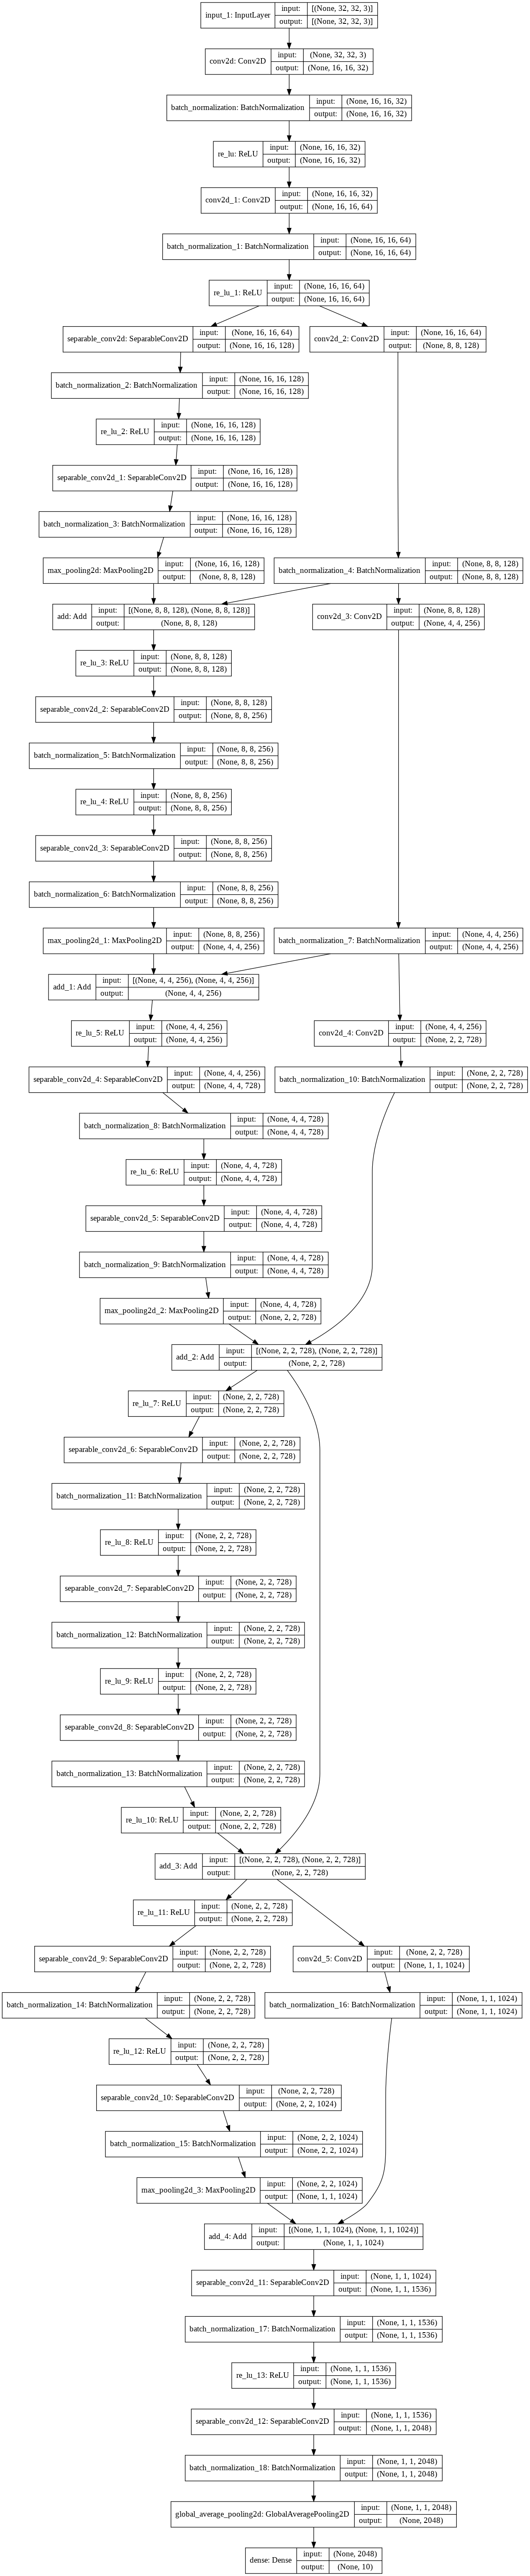

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Here I create a dirctory for the first model to be saved and define the checkpoints and learning rate reduction for model training.

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_xception_relu.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

Now I compile the model using the adam optimizer and train the model for 12 epochs.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_callback = model.fit(x_train, y_train, validation_split= 0.2, epochs= 12, callbacks=callbacks)

Epoch 1/12
1250/1250 [==============================] - 42s 19ms/step - loss: 1.4678 - accuracy: 0.4672 - val_loss: 1.4248 - val_accuracy: 0.5345

Epoch 00001: val_loss improved from inf to 1.42480, saving model to /content/saved_models/cifar10_xception_relu.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/12
1250/1250 [==============================] - 23s 18ms/step - loss: 1.0764 - accuracy: 0.6208 - val_loss: 1.0675 - val_accuracy: 0.6254

Epoch 00002: val_loss improved from 1.42480 to 1.06747, saving model to /content/saved_models/cifar10_xception_relu.h5
Epoch 3/12
1250/1250 [==============================] - 24s 19ms/step - loss: 0.8760 - accuracy: 0.6958 - val_loss: 0.9499 - val_accuracy: 0.6662

Epoch 00003: val_loss improved from 1.06747 to 0.94994, saving model to /content/saved_models/cifar10_xception_relu.h5
Epoch 4/12
1250/1250 [==============================] - 24s 19ms/step - loss: 0.7388 - accuracy: 0.7456 - val_loss: 1.0383 - val_accuracy: 0.6437

Epoch 00004: val_loss did not improve from 0.94994
Epoch 5/12
1250/1250 [==============================] - 24s 19ms/step - loss: 0.6239 - accuracy: 0.7857 - val_loss: 0.8871 - val_accuracy: 0.7076

Epoch 00005: val_loss improved from 0.94994 to 0.88706, saving model to /content/saved_models/cifar10_xception_relu.h5
Epoc

The plot below shows the training and validation accuracy for each epoch of training. From the graph we can see that the training accuracy steadily increases in every epoch while the validation accuracy begins to decline after the eighth epoch. This could be a sign that the model is overfitting.

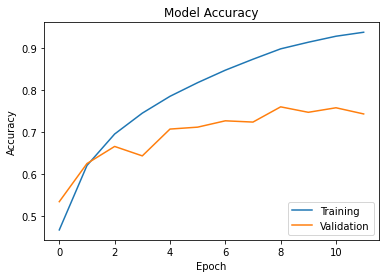

In [ ]:
plt.figure()
plt.plot(h_callback.history['accuracy'])
plt.plot(h_callback.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

Evaluating on the test data yields an accuracy of 73.67%.

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 1.0425 - accuracy: 0.7367


[1.0424778461456299, 0.7366999983787537]

Here I alter the entry, middle and exit flows changing the activation function from ReLu to ELU to see if it affects the performance of the model.

In [ ]:
def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ELU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ELU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ELU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ELU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ELU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ELU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ELU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ELU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ELU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ELU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ELU()(x)
        tensor = Add()([tensor,x])
        
        return tensor
# exit flow

def exit_flow(tensor):
    
    x = ELU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ELU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ELU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units = 10, activation = 'softmax')(x)
    
    return x

In [ ]:
input = Input(shape = (32,32,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model (inputs=input, outputs=output)

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_xception_elu.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

Now I compile and train the model with the only change being the intermediate activation function.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_callback2 = model.fit(x_train, y_train, validation_split= 0.2, epochs= 12, callbacks=callbacks)

Epoch 1/12
1250/1250 [==============================] - 26s 19ms/step - loss: 1.3200 - accuracy: 0.5170 - val_loss: 1.5040 - val_accuracy: 0.5209

Epoch 00001: val_loss improved from inf to 1.50403, saving model to /content/saved_models/cifar10_xception_elu.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/12
1250/1250 [==============================] - 24s 19ms/step - loss: 0.9775 - accuracy: 0.6533 - val_loss: 1.2562 - val_accuracy: 0.5778

Epoch 00002: val_loss improved from 1.50403 to 1.25621, saving model to /content/saved_models/cifar10_xception_elu.h5
Epoch 3/12
1250/1250 [==============================] - 23s 18ms/step - loss: 0.7997 - accuracy: 0.7233 - val_loss: 1.1067 - val_accuracy: 0.6143

Epoch 00003: val_loss improved from 1.25621 to 1.10670, saving model to /content/saved_models/cifar10_xception_elu.h5
Epoch 4/12
1250/1250 [==============================] - 23s 18ms/step - loss: 0.6823 - accuracy: 0.7623 - val_loss: 0.8531 - val_accuracy: 0.7113

Epoch 00004: val_loss improved from 1.10670 to 0.85307, saving model to /content/saved_models/cifar10_xception_elu.h5
Epoch 5/12
1250/1250 [==============================] - 23s 18ms/step - loss: 0.5707 - accuracy: 0.8051 - val_loss: 0.8314 - val_accuracy: 0.7200

Epoch 00005: val_loss improved from 0.85307 to 0.83143, sa

From the graph below we can see that the accuracy continues to increase in later epochs with the ELU activation function. This is an imporvement compared to the ReLu activation function.

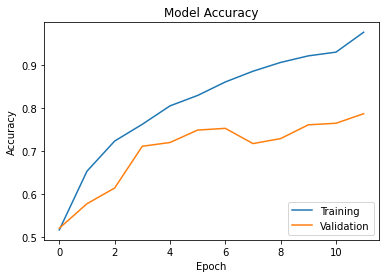

In [ ]:
plt.figure()
plt.plot(h_callback2.history['accuracy'])
plt.plot(h_callback2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

The accuracy of this model when predicting on the test data is 77.86% which is approximately a 4% improvement over the model using ReLU.

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.8974 - accuracy: 0.7786


[0.8974444270133972, 0.7785999774932861]

Finally I create the model with no intermediate activation function.

In [ ]:
# entry flow
def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    tensor = conv_bn(x, filters =64, kernel_size =3, strides=1)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])

    x = sep_bn(x, filters =256, kernel_size=3)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters =728, kernel_size=3)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x

# middle flow
def middle_flow(tensor):
    
    for _ in range(8):
        x = sep_bn(tensor, filters = 728, kernel_size = 3)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        tensor = Add()([tensor,x])
        
        return tensor

# exit flow
def exit_flow(tensor):
    
    x = sep_bn(tensor, filters = 728,  kernel_size=3)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units = 10, activation = 'softmax')(x)
    
    return x

In [ ]:
input = Input(shape = (32,32,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model (inputs=input, outputs=output)

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_xception_no_act.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_callback3 = model.fit(x_train, y_train, validation_split= 0.2, epochs= 12, callbacks=callbacks)

Epoch 1/12
1250/1250 [==============================] - 25s 19ms/step - loss: 1.4709 - accuracy: 0.4670 - val_loss: 1.5411 - val_accuracy: 0.4979

Epoch 00001: val_loss improved from inf to 1.54113, saving model to /content/saved_models/cifar10_xception_no_act.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/12
1250/1250 [==============================] - 24s 19ms/step - loss: 1.0945 - accuracy: 0.6127 - val_loss: 1.0678 - val_accuracy: 0.6301

Epoch 00002: val_loss improved from 1.54113 to 1.06777, saving model to /content/saved_models/cifar10_xception_no_act.h5
Epoch 3/12
1250/1250 [==============================] - 23s 18ms/step - loss: 0.9221 - accuracy: 0.6776 - val_loss: 0.9050 - val_accuracy: 0.6912

Epoch 00003: val_loss improved from 1.06777 to 0.90498, saving model to /content/saved_models/cifar10_xception_no_act.h5
Epoch 4/12
1250/1250 [==============================] - 23s 18ms/step - loss: 0.7883 - accuracy: 0.7281 - val_loss: 0.9342 - val_accuracy: 0.7006

Epoch 00004: val_loss did not improve from 0.90498
Epoch 5/12
1250/1250 [==============================] - 23s 18ms/step - loss: 0.6844 - accuracy: 0.7646 - val_loss: 0.7581 - val_accuracy: 0.7447

Epoch 00005: val_loss improved from 0.90498 to 0.75811, saving model to /content/saved_models/cifar10_xception_no_act.h

From the plot below we can see that the training accuracy increases steadily however the validation accuracy begins to plateau in the later epochs.

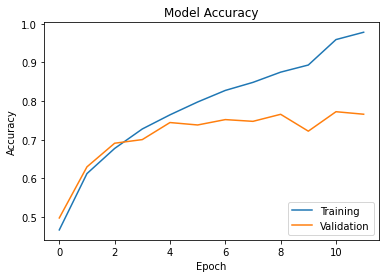

In [ ]:
plt.figure()
plt.plot(h_callback3.history['accuracy'])
plt.plot(h_callback3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

The accuracy of the predictions on the test data is 76.08% which is a higher accuracy than the model using ReLu but lower than the model using ELU.

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 1.0439 - accuracy: 0.7608


[1.0439432859420776, 0.7608000040054321]

Plotting all the validation accuracy scores we see that in the beginning epochs all of the models are fairly close together. Towards later epochs ELU is the only model that is still increasing significantly in accuracy and thus it had the highest testing accuracy.

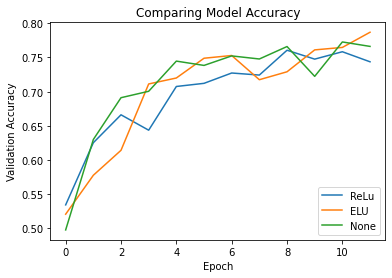

In [ ]:
plt.figure()
plt.plot(h_callback.history['val_accuracy'])
plt.plot(h_callback2.history['val_accuracy'])
plt.plot(h_callback3.history['val_accuracy'])
plt.title('Comparing Model Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['ReLu', 'ELU', 'None'], loc='lower right')
plt.show()

The prediction accuracy for each variation of the Xception model is as follows

Activation|Accuracy
-----|-----
ReLu|73.67%
ELU|77.86%
None|76.08%

# Summary

In this report I wanted to test to see which activation function performed the best using the Xception model on the Cifar-10 data. The ELU performed the best, followed by no activation function while ReLU performed the worst.

This result is slightly than the results in the Xception paper where no activation function out performed the ELU activation function. However the ReLu function was the worst when training the Xception on both Cifar-10 and ImageNet.

I believe this demonstrates that the activation function for used for an architecture may be optimal for one dataset but not another. It also demonstatres that ReLu activation may not be the best choice as it performed worse on both datasets.